Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning timm --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 26
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'efficientnet_b0'
BATCH_SIZE = 128
NUM_EPOCHS = 500

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import timm
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
# from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp026'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 20:06:11,416 - __main__ - INFO - Experiment no: 26
2021-07-21 20:06:11,420 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 20:06:11,422 - __main__ - INFO - SEED: 1
2021-07-21 20:06:11,425 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 20:06:11,439 - __main__ - DEBUG - Start loading csv files (0.007 seconds passed)
2021-07-21 20:06:11,471 - __main__ - DEBUG - Complete loading csv files (0.039 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 20:06:11,679 - __main__ - DEBUG - Start fold 1 (0.247 seconds passed)
2021-07-21 20:06:11,685 - __main__ - DEBUG - Start training model (0.253 seconds passed)
2021-07-21 20:06:14,327 - __main__ - DEBUG - Epoch 0/499
2021-07-21 20:07:21,739 - __main__ - DEBUG - train Loss: 1.5871
2021-07-21 20:08:23,362 - __main__ - DEBUG - val Loss: 0.9953
2021-07-21 20:08:23,385 - __main__ - DEBUG - Epoch 1/499
2021-07-21 20:08:35,177 - __main__ - DEBUG - train Loss: 1.0667
2021-07-21 20:08:37,177 - __main__ - DEBUG - val Loss: 0.9889
2021-07-21 20:08:37,205 - __main__ - DEBUG - Epoch 2/499
2021-07-21 20:08:48,909 - __main__ - DEBUG - train Loss: 1.0115
2021-07-21 20:08:50,806 - __main__ - DEBUG - val Loss: 0.8863
2021-07-21 20:08:50,827 - __main__ - DEBUG - Epoch 3/499
2021-07-21 20:09:02,332 - __main__ - DEBUG - train Loss: 0.9534
2021-07-21 20:09:04,186 - __main__ - DEBUG - val Loss: 0.8747
2021-07-21 20:09:04,207 - __main__ - DEBUG - Epoch 4/499
2021-07-21 20:09:15,721 - __main__ - DEBU

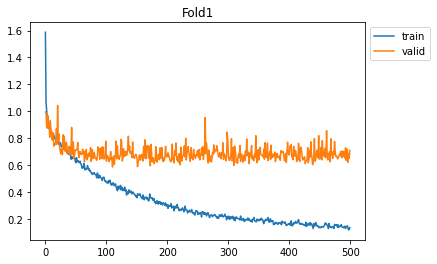

2021-07-21 22:01:07,070 - __main__ - DEBUG - Complete prediction for train fold (6895.638 seconds passed)
2021-07-21 22:01:08,905 - __main__ - DEBUG - Complete prediction for val fold (6897.473 seconds passed)
2021-07-21 22:08:13,704 - __main__ - DEBUG - Complete prediction for test fold (7322.272 seconds passed)
2021-07-21 22:08:13,725 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp026/cv_fold1_training.csv (7322.294 seconds passed)
2021-07-21 22:08:13,733 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp026/cv_fold1_validation.csv (7322.301 seconds passed)
2021-07-21 22:08:13,753 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp026/cv_fold1_test.csv (7322.321 seconds passed)
2021-07-21 22:08:13,846 - __main__ - DEBUG - Save model ../scripts/../experiments/exp026/cv_fold1_model.torch (7322.414 seconds passed)
2021-07-21 22:08:13,960 - __main__ - DEBUG - Complete fold 1 (7322.528 seconds passed)
2021-07-21 22:08:13,963

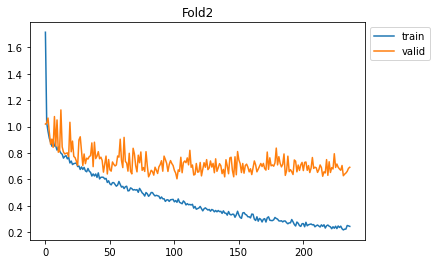

2021-07-21 23:02:04,206 - __main__ - DEBUG - Complete prediction for train fold (10552.775 seconds passed)
2021-07-21 23:02:06,188 - __main__ - DEBUG - Complete prediction for val fold (10554.756 seconds passed)
2021-07-21 23:02:16,847 - __main__ - DEBUG - Complete prediction for test fold (10565.415 seconds passed)
2021-07-21 23:02:16,864 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp026/cv_fold2_training.csv (10565.432 seconds passed)
2021-07-21 23:02:16,872 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp026/cv_fold2_validation.csv (10565.440 seconds passed)
2021-07-21 23:02:16,890 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp026/cv_fold2_test.csv (10565.459 seconds passed)
2021-07-21 23:02:16,972 - __main__ - DEBUG - Save model ../scripts/../experiments/exp026/cv_fold2_model.torch (10565.540 seconds passed)
2021-07-21 23:02:17,085 - __main__ - DEBUG - Complete fold 2 (10565.654 seconds passed)
2021-07-21 23:0

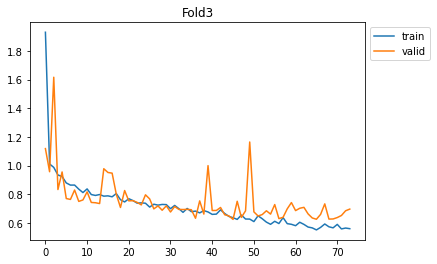

2021-07-21 23:19:08,887 - __main__ - DEBUG - Complete prediction for train fold (11577.456 seconds passed)
2021-07-21 23:19:10,777 - __main__ - DEBUG - Complete prediction for val fold (11579.345 seconds passed)
2021-07-21 23:19:20,893 - __main__ - DEBUG - Complete prediction for test fold (11589.462 seconds passed)
2021-07-21 23:19:20,911 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp026/cv_fold3_training.csv (11589.480 seconds passed)
2021-07-21 23:19:20,923 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp026/cv_fold3_validation.csv (11589.491 seconds passed)
2021-07-21 23:19:20,943 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp026/cv_fold3_test.csv (11589.511 seconds passed)
2021-07-21 23:19:21,025 - __main__ - DEBUG - Save model ../scripts/../experiments/exp026/cv_fold3_model.torch (11589.593 seconds passed)
2021-07-21 23:19:21,147 - __main__ - DEBUG - Complete fold 3 (11589.715 seconds passed)
2021-07-21 23:1

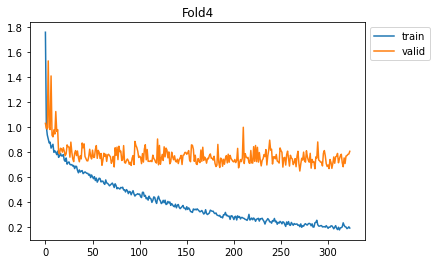

2021-07-22 00:33:07,451 - __main__ - DEBUG - Complete prediction for train fold (16016.019 seconds passed)
2021-07-22 00:33:09,327 - __main__ - DEBUG - Complete prediction for val fold (16017.895 seconds passed)
2021-07-22 00:33:19,713 - __main__ - DEBUG - Complete prediction for test fold (16028.281 seconds passed)
2021-07-22 00:33:19,731 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp026/cv_fold4_training.csv (16028.299 seconds passed)
2021-07-22 00:33:19,739 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp026/cv_fold4_validation.csv (16028.307 seconds passed)
2021-07-22 00:33:19,762 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp026/cv_fold4_test.csv (16028.330 seconds passed)
2021-07-22 00:33:19,844 - __main__ - DEBUG - Save model ../scripts/../experiments/exp026/cv_fold4_model.torch (16028.412 seconds passed)
2021-07-22 00:33:19,980 - __main__ - DEBUG - Complete fold 4 (16028.548 seconds passed)
2021-07-22 00:3

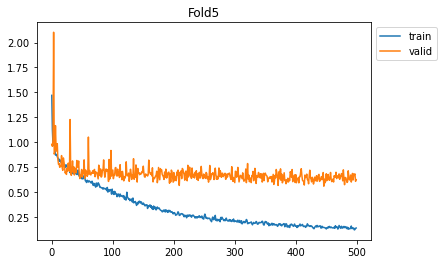

2021-07-22 02:28:18,171 - __main__ - DEBUG - Complete prediction for train fold (22926.739 seconds passed)
2021-07-22 02:28:20,128 - __main__ - DEBUG - Complete prediction for val fold (22928.696 seconds passed)
2021-07-22 02:28:31,342 - __main__ - DEBUG - Complete prediction for test fold (22939.910 seconds passed)
2021-07-22 02:28:31,364 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp026/cv_fold5_training.csv (22939.932 seconds passed)
2021-07-22 02:28:31,374 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp026/cv_fold5_validation.csv (22939.942 seconds passed)
2021-07-22 02:28:31,395 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp026/cv_fold5_test.csv (22939.963 seconds passed)
2021-07-22 02:28:31,486 - __main__ - DEBUG - Save model ../scripts/../experiments/exp026/cv_fold5_model.torch (22940.054 seconds passed)
2021-07-22 02:28:31,643 - __main__ - DEBUG - Complete fold 5 (22940.211 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    ## Refference: 
    ## https://www.guruguru.science/competitions/17/discussions/617a31cb-11b8-423d-972a-738ee060e8d1/
    # model, input_size = initialize_model(MODEL_NAME)
    input_size = 224
    model = timm.create_model(MODEL_NAME, pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=32, bias=True),
        nn.Dropout(0.2),
        nn.Linear(in_features=32, out_features=1, bias=True)
    )
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-22 02:28:31,699 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-22 02:28:31,725 - __main__ - DEBUG - Loss: 0.5877151464512932
2021-07-22 02:28:31,726 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-22 02:28:31,737 - __main__ - DEBUG - Loss: 0.546760678488247
2021-07-22 02:28:31,738 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-22 02:28:31,750 - __main__ - DEBUG - Loss: 0.7189690931658842
2021-07-22 02:28:31,751 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-22 02:28:31,761 - __main__ - DEBUG - Loss: 0.3348259595486346
2021-07-22 02:28:31,762 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-22 02:28:31,772 - __main__ - DEBUG - Loss: 0.24543926727753093


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.06854,1
00309fb1ef05416f9c1f,2.19383,3
003a1562e97f79ba96dc,2.20310,3
004890880e8e7431147b,0.78872,2
00718c32602425f504c1,2.13667,3
...,...,...
ffa3259fff8e6f3818a1,2.03826,3
ffd4d361756587883e48,0.80522,1
ffd794b7b311b7b7fd92,1.64970,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-22 02:28:31,818 - __main__ - INFO - Training loss: 0.6384245741084797


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-22 02:28:31,840 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp026/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-22 02:28:31,867 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-22 02:28:31,876 - __main__ - DEBUG - Loss: 0.765881225990255
2021-07-22 02:28:31,877 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-22 02:28:31,885 - __main__ - DEBUG - Loss: 0.7776252310777803
2021-07-22 02:28:31,886 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-22 02:28:31,895 - __main__ - DEBUG - Loss: 0.789997721529882
2021-07-22 02:28:31,896 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-22 02:28:31,903 - __main__ - DEBUG - Loss: 0.8046887161061987
2021-07-22 02:28:31,904 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-22 02:28:31,912 - __main__ - DEBUG - Loss: 0.7463637718830589


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.30699,1
00309fb1ef05416f9c1f,0.47066,3
003a1562e97f79ba96dc,0.53763,3
004890880e8e7431147b,0.22275,2
00718c32602425f504c1,0.57796,3
...,...,...
ffa3259fff8e6f3818a1,0.37671,3
ffd4d361756587883e48,0.18681,1
ffd794b7b311b7b7fd92,0.47191,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-22 02:28:31,948 - __main__ - INFO - Validatino loss: 1.7010654801807874


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-22 02:28:31,989 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp026/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-22 02:28:32,001 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp026/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.35736
000bd5e82eb22f199f44,2.30329
0015f44de1854f617516,1.68322
00388a678879ba1efa27,1.99353
005e1e7c6496902d23f3,0.81748
...,...
ffbe65ad399b632dcbd0,1.65031
ffd7b2d646c0320c311a,1.00678
ffdb93ede17d4501e530,1.69333


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.35736
1,2.30329
2,1.68322
3,1.99353
4,0.81748
...,...
5914,1.65031
5915,1.00678
5916,1.69333
5917,1.78084


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-22 02:28:32,124 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp026/026_submission.csv


2021-07-22 02:28:32,262 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp026/prediction.png


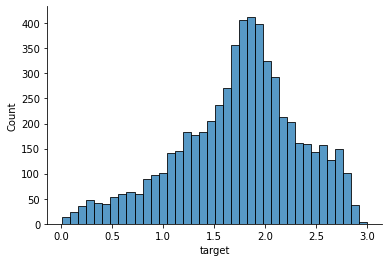

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-22 02:28:32,434 - __main__ - DEBUG - Complete (22941.003 seconds passed)
